# [Java中volatile关键字详解](https://www.cnblogs.com/zhengbin/p/5654805.html)

## 基本概念
**先补充一下概念：Java 内存模型中的`可见性`、`原子性`和`有序性`。**

**可见性：可见性，是指线程之间的可见性，一个线程修改的状态对另一个线程是可见的。**

也就是一个线程修改的结果。另一个线程马上就能看到。比如：用`volatile修饰`的变量，就会具有可见性。volatile修饰的变量不允许线程内部缓存和重排序，即直接修改内存。所以对其他线程是可见的。但是这里需要注意一个问题，volatile只能让被他修饰内容具有可见性，但不能保证它具有原子性。比如 volatile int a = 0；之后有一个操作 a++；这个变量a具有可见性，但是a++ 依然是一个非原子操作，也就是这个操作同样存在线程安全问题。

可见性是一种复杂的属性，因为可见性中的错误总是会违背我们的直觉。通常，我们无法确保执行读操作的线程能适时地看到其他线程写入的值，有时甚至是根本不可能的事情。为了确保多个线程之间对内存写入操作的可见性，必须使用同步机制。

**在 Java 中 volatile、synchronized 和 final 实现可见性。**

**原子性：原子是世界上的最小单位，具有不可分割性。一个操作是原子操作，那么我们称它具有原子性。**

比如 a=0；（a非long和double类型） 这个操作是不可分割的，那么我们说这个操作时原子操作。再比如：a++； 这个操作实际是a = a + 1；是可分割的，所以他不是一个原子操作。非原子操作都会存在线程安全问题，需要我们使用同步技术（sychronized）来让它变成一个原子操作。一个操作是原子操作，那么我们称它具有原子性。java的concurrent包下提供了一些原子类，我们可以通过阅读API来了解这些原子类的用法。比如：AtomicInteger、AtomicLong、AtomicReference等。

**在 Java 中 synchronized 和在 lock、unlock 中操作保证原子性。**

**有序性：**

Java 语言提供了 volatile 和 synchronized 两个关键字来保证线程之间操作的有序性，volatile 是因为其本身包含“禁止指令重排序”的语义，synchronized 是由“一个变量在同一个时刻只允许一条线程对其进行 lock 操作”这条规则获得的，此规则决定了持有同一个对象锁的两个同步块只能串行执行。

**下面内容摘录自《Java Concurrency in Practice》：**

下面一段代码在多线程环境下，将存在问题。

In [2]:
public class NoVisibility {
     private static boolean ready;
     private static int number;
     private static class ReaderThread extends Thread {
         @Override
         public void run() {
             while(!ready) {
                 Thread.yield();
             }
             System.out.println(number);
         }
     }
     public static void main(String[] args) {
         new ReaderThread().start();
         number = 42;
         ready = true;
     }
}

　　NoVisibility可能会持续循环下去，因为读线程可能永远都看不到ready的值。甚至NoVisibility可能会输出0，因为读线程可能看到了写入ready的值，但却没有看到之后写入number的值，这种现象被称为“重排序”。只要在某个线程中无法检测到重排序情况（即使在其他线程中可以明显地看到该线程中的重排序），那么就无法确保线程中的操作将按照程序中指定的顺序来执行。当主线程首先写入number，然后在没有同步的情况下写入ready，那么读线程看到的顺序可能与写入的顺序完全相反。

　　在没有同步的情况下，编译器、处理器以及运行时等都可能对操作的执行顺序进行一些意想不到的调整。在缺乏足够同步的多线程程序中，要想对内存操作的执行春旭进行判断，无法得到正确的结论。

　　这个看上去像是一个失败的设计，但却能使JVM充分地利用现代多核处理器的强大性能。例如，在缺少同步的情况下，Java内存模型允许编译器对操作顺序进行重排序，并将数值缓存在寄存器中。此外，它还允许CPU对操作顺序进行重排序，并将数值缓存在处理器特定的缓存中。

### 补充：重排序
#### 什么是重排序？
执行任务的时候，为了提高编译器和处理器的执行性能，编译器和处理器(包括内存系统，内存在行为没有重排但是存储的时候是有变化的)会对指令重排序。编译器优化的重排序是在编译时期完成的，指令重排序和内存重排序是处理器重排序

1. 编译器优化的重排序，在不改变单线程语义的情况下重新安排语句的执行顺序
2. 指指令级并行重排序，处理器的指令级并行技术将多条指令重叠执行，如果不存在数据的依赖性将会改变语句对应机器指令的执行顺序
3. 内存系统的重排序，因为使用了读写缓存区，使得看起来并不是顺序执行的

#### 重排序会产生什么问题
1. 重排序可能会导致多线程程序出现内存可见性问题。(工作内存和主内存，编译器处理器重排序导致的可见性）
2. 重排序会导致有序性问题，程序的读写顺序于内存的读写顺序不一样（编译器处理器重排序，内存缓冲区(是处理器重排序的内容))

#### happen-before
java内存模型中提供的happens-before辅助保证程序执行的原子性可见性和有序性的问题，是判断线程是否存在竞争，线程是否安全的依据

java内存模型提供了8种happen-before规则，帮助实现原子性可见性和有序性，**在执行程序的时候查看是否满足happen-before的8种规则，如果满足的话就能够保证线程安全**

1. **程序顺序原则**：一个线程内要按照代码的顺序执行，保证语义的串行性
2. **锁规则**：解锁操作必须发生在对同一个锁的加锁操作之前
3. **volatile规则**：对volatile修饰的变量的写操作发生在volatile变量的读操作之前。访问volatile的变量时候强制从主内存中进行读取，volatile修饰的变量被修改之后会被强制的刷新到主内存中。所以说volatile修饰的变量保证了可见性
4. **线程启动规则**：线程的start()方法最先执行，线程A在线程B执行start()方法之前对共享变量的修改对线程B可见
5. **线程终止规则**：线程的所有操作优于线程的终结，Thread.join()方法的作用是等待当前线程终止，线程B在终止之前修改了共享变量，执行完成后，线程B对共享变量的修改将对线程A可见
6. **线程中断规则**：对线程interrupt中断方法的调用发生在被中断的线程检测到中断事件的发生之前
7. **对象终结规则**：对象的构造函数执行完成先于finalize()方法
8. **传递性**：线程A生在线程B之前，线程B发生在线程C之前，则线程A发生在线程C之前

## volatile原理
　　Java语言提供了一种稍弱的同步机制，即**volatile变量，用来确保将变量的更新操作通知到其他线程。当把变量声明为volatile类型后，编译器与运行时都会注意到这个变量是共享的，因此不会将该变量上的操作与其他内存操作一起重排序**。volatile变量不会被缓存在寄存器或者对其他处理器不可见的地方，因此在读取volatile类型的变量时总会返回最新写入的值。
　　**<p style="color:red">在访问volatile变量时不会执行加锁操作，因此也就不会使执行线程阻塞，因此volatile变量是一种比sychronized关键字更轻量级的同步机制。</p>**

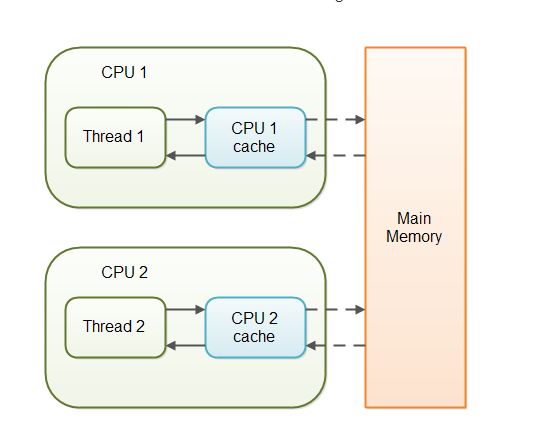
    当对非 volatile 变量进行读写的时候，每个线程先从内存拷贝变量到CPU缓存中。如果计算机有多个CPU，每个线程可能在不同的CPU上被处理，这意味着每个线程可以拷贝到不同的 CPU cache 中。
　　**<p style="color:red">而声明变量是 volatile 的，JVM 保证了每次读变量都从内存中读，跳过 CPU cache 这一步。</p>**

### 特性
**当一个变量定义为 volatile 之后，将具备两种特性：**
1. 保证此变量对所有的线程的可见性，这里的“可见性”，如本文开头所述，当一个线程修改了这个变量的值，volatile 保证了新值能立即同步到主内存，以及每次使用前立即从主内存刷新。但普通变量做不到这点，普通变量的值在线程间传递均需要通过主内存（详见：[Java内存模型](https://www.cnblogs.com/zhengbin/p/6407137.html)）来完成。

2. 禁止指令重排序优化。有volatile修饰的变量，赋值后多执行了一个“load addl $0x0, (%esp)”操作，这个操作相当于一个内存屏障（指令重排序时不能把后面的指令重排序到内存屏障之前的位置），只有一个CPU访问内存时，并不需要内存屏障；（什么是指令重排序：是指CPU采用了允许将多条指令不按程序规定的顺序分开发送给各相应电路单元处理）。

### 性能
volatile 的读性能消耗与普通变量几乎相同，但是写操作稍慢，因为它需要在本地代码中插入许多内存屏障指令来保证处理器不发生乱序执行。